In [3]:
!pip install geopandas

   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/19.2 MB 5.6 MB/s eta 0:00:04
   --- ------------------------------------ 1.8/19.2 MB 5.3 MB/s eta 0:00:04
   ------ --------------------------------- 2.9/19.2 MB 4.9 MB/s eta 0:00:04
   ------- -------------------------------- 3.7/19.2 MB 4.8 MB/s eta 0:00:04
   --------- ------------------------------ 4.7/19.2 MB 4.8 MB/s eta 0:00:03
   ------------ --------------------------- 5.8/19.2 MB 5.0 MB/s eta 0:00:03
   -------------- ------------------------- 7.1/19.2 MB 5.0 MB/s eta 0:00:03
   ---------------- ----------------------- 8.1/19.2 MB 5.0 MB/s eta 0:00:03
   ------------------ --------------------- 8.9/19.2 MB 5.0 MB/s eta 0:00:03
   -------------------- ------------------- 9.7/19.2 MB 5.0 MB/s eta 0:00:02
   ---------------------- ----------------- 10.7/19.2 MB 4.9 MB/s eta 0:00:02
   ------------------------ --------------- 11.8/19.2 MB 4.9 MB/s eta 0:00:02
   -

In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
from urllib.parse import urljoin
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

In [7]:

def baixar_shapefile_ibge():
    """
    Baixa o shapefile de municípios do IBGE
    """
    # URL do shapefile de municípios do IBGE (2022)
    url = "https://geoftp.ibge.gov.br/organizacao_do_territorio/malhas_territoriais/malhas_municipais/municipio_2022/Brasil/BR/BR_Municipios_2022.zip"
    
    # Nome do arquivo local
    nome_arquivo = "BR_Municipios_2022.zip"
    pasta_dados = "dados_ibge"
    
    # Criar pasta se não existir
    if not os.path.exists(pasta_dados):
        os.makedirs(pasta_dados)
    
    caminho_zip = os.path.join(pasta_dados, nome_arquivo)
    
    # Verificar se já foi baixado
    if not os.path.exists(caminho_zip):
        print("Baixando shapefile do IBGE...")
        response = requests.get(url)
        with open(caminho_zip, 'wb') as f:
            f.write(response.content)
        print("Download concluído!")
    
    # Extrair o arquivo zip
    pasta_extracao = os.path.join(pasta_dados, "municipios")
    if not os.path.exists(pasta_extracao):
        print("Extraindo arquivos...")
        with zipfile.ZipFile(caminho_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_extracao)
        print("Extração concluída!")
    
    # Encontrar o arquivo .shp
    for arquivo in os.listdir(pasta_extracao):
        if arquivo.endswith('.shp'):
            return os.path.join(pasta_extracao, arquivo)
    
    raise FileNotFoundError("Arquivo shapefile não encontrado")

def normalizar_nome_municipio(nome):
    """
    Normaliza nomes de municípios para facilitar o join
    """
    import unicodedata
    # Remove acentos
    nome = unicodedata.normalize('NFD', nome)
    nome = ''.join(c for c in nome if unicodedata.category(c) != 'Mn')
    # Converte para maiúsculo e remove espaços extras
    return nome.upper().strip()

def criar_mapa_municipios(df_dados, coluna_municipio='municipio', coluna_valor='valor', 
                         titulo='Mapa do Brasil por Municípios', 
                         label_colorbar='Valor',
                         colormap='viridis',
                         figsize=(15, 12)):
    """
    Cria mapa do Brasil com municípios coloridos por valores
    
    Parâmetros:
    - df_dados: DataFrame com colunas de município e valor
    - coluna_municipio: nome da coluna com nomes dos municípios
    - coluna_valor: nome da coluna com os valores para colorir
    - titulo: título do mapa
    - label_colorbar: label da barra de cores
    - colormap: colormap do matplotlib (ex: 'viridis', 'plasma', 'coolwarm')
    - figsize: tamanho da figura
    """
    
    # Baixar e carregar shapefile
    caminho_shapefile = baixar_shapefile_ibge()
    print("Carregando shapefile...")
    gdf_municipios = gpd.read_file(caminho_shapefile)
    
    # Normalizar nomes dos municípios no GeoDataFrame
    gdf_municipios['NM_MUN_NORM'] = gdf_municipios['NM_MUN'].apply(normalizar_nome_municipio)
    
    # Preparar dados
    df_trabalho = df_dados.copy()
    df_trabalho['municipio_norm'] = df_trabalho[coluna_municipio].apply(normalizar_nome_municipio)
    
    # Fazer o join
    print("Realizando join dos dados...")
    gdf_final = gdf_municipios.merge(
        df_trabalho, 
        left_on='NM_MUN_NORM', 
        right_on='municipio_norm', 
        how='left'
    )
    
    # Estatísticas do join
    municipios_com_dados = gdf_final[coluna_valor].notna().sum()
    total_municipios = len(gdf_final)
    print(f"Join realizado: {municipios_com_dados}/{total_municipios} municípios com dados")
    
    # Criar o mapa
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plotar municípios sem dados (cinza claro)
    gdf_sem_dados = gdf_final[gdf_final[coluna_valor].isna()]
    if not gdf_sem_dados.empty:
        gdf_sem_dados.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.1)
    
    # Plotar municípios com dados
    gdf_com_dados = gdf_final[gdf_final[coluna_valor].notna()]
    if not gdf_com_dados.empty:
        im = gdf_com_dados.plot(
            ax=ax, 
            column=coluna_valor, 
            cmap=colormap,
            edgecolor='white', 
            linewidth=0.1,
            legend=False
        )
        
        # Adicionar colorbar
        sm = plt.cm.ScalarMappable(
            cmap=colormap, 
            norm=plt.Normalize(vmin=gdf_com_dados[coluna_valor].min(), 
                              vmax=gdf_com_dados[coluna_valor].max())
        )
        sm.set_array([])
        cbar = fig.colorbar(sm, ax=ax, shrink=0.6, aspect=20)
        cbar.set_label(label_colorbar, rotation=270, labelpad=20)
    
    # Configurar o mapa
    ax.set_title(titulo, fontsize=16, fontweight='bold', pad=20)
    ax.set_axis_off()
    
    # Ajustar layout
    plt.tight_layout()
    
    return fig, ax, gdf_final


Criando dados de exemplo...
Baixando shapefile do IBGE...
Download concluído!
Extraindo arquivos...
Extração concluída!
Carregando shapefile...
Realizando join dos dados...
Join realizado: 29/5572 municípios com dados


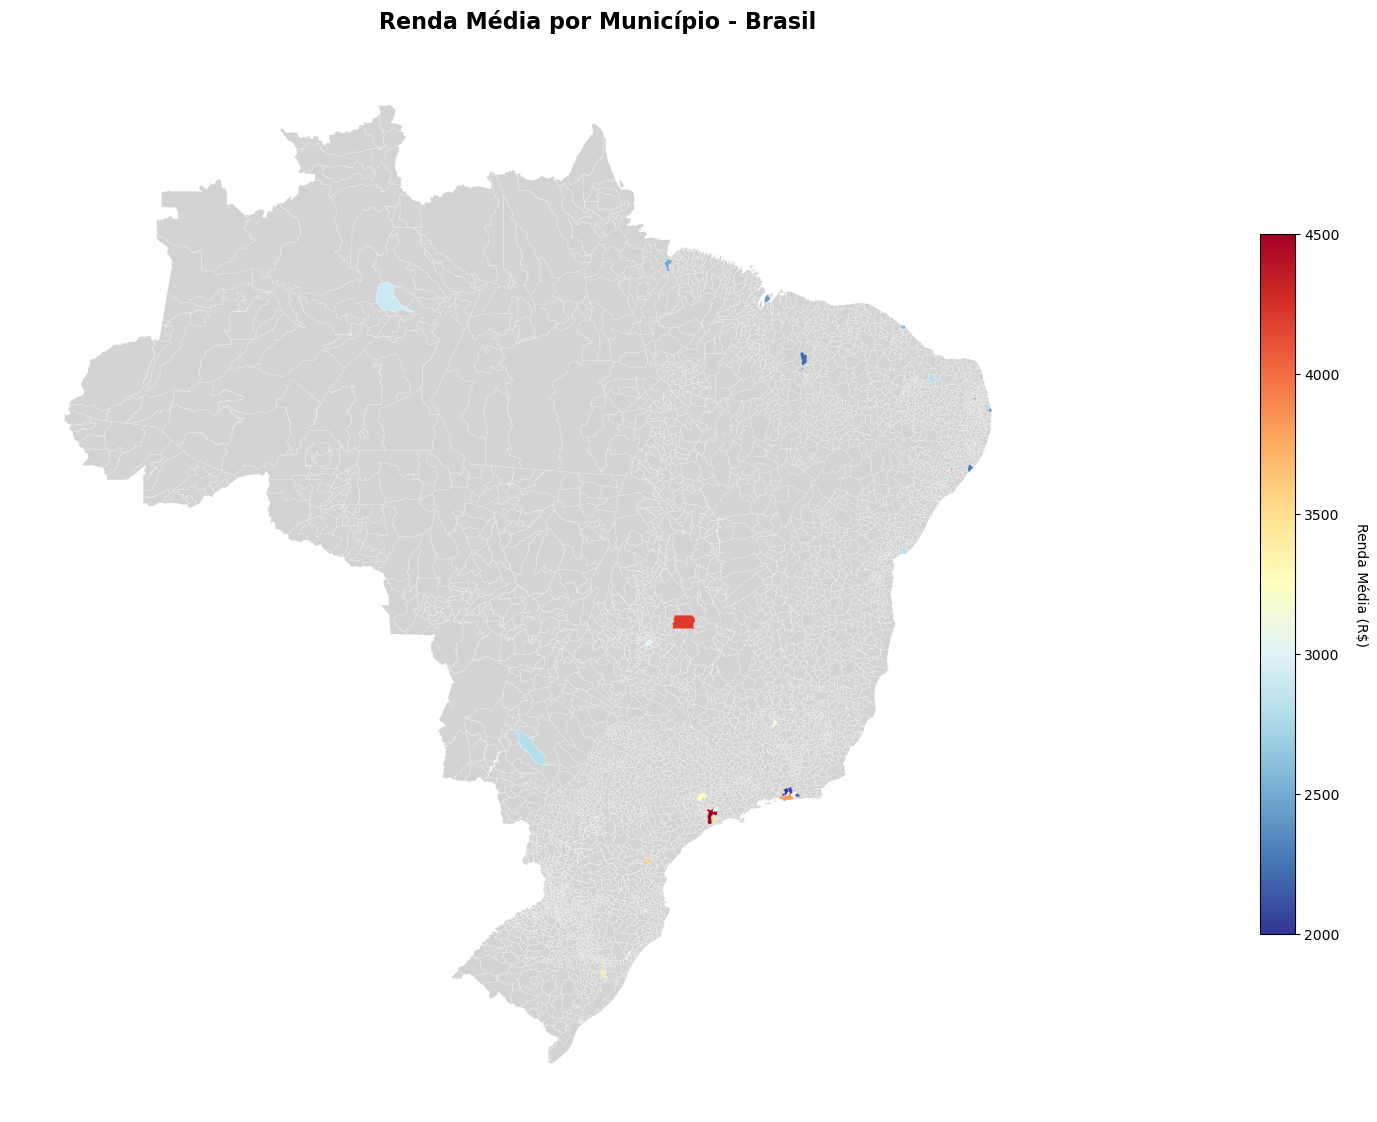

Mapa salvo como 'mapa_brasil_municipios.png'

=== ESTATÍSTICAS ===
Total de municípios no shapefile: 5572
Municípios com dados: 29
Valor mínimo: R$ 2000
Valor máximo: R$ 4500
Valor médio: R$ 2893


In [9]:

# Criar dados de exemplo
print("Criando dados de exemplo...")
dados_exemplo = pd.DataFrame({
    'municipio': [
        'São Paulo', 'Rio de Janeiro', 'Belo Horizonte', 'Salvador', 
        'Brasília', 'Fortaleza', 'Manaus', 'Curitiba', 'Recife', 
        'Porto Alegre', 'Goiânia', 'Belém', 'Guarulhos', 'Campinas',
        'São Luís', 'São Gonçalo', 'Maceió', 'Duque de Caxias',
        'Natal', 'Campo Grande', 'Teresina', 'Nova Iguaçu',
        'São Bernardo do Campo', 'João Pessoa', 'Osasco'
    ],
    'renda_media': [
        4500, 3800, 3200, 2800, 4200, 2600, 2900, 3600, 2700,
        3400, 3000, 2500, 3100, 3300, 2400, 2200, 2300, 2100,
        2600, 2800, 2200, 2000, 3500, 2400, 3200
    ]
})

# Criar o mapa
fig, ax, gdf_resultado = criar_mapa_municipios(
    df_dados=dados_exemplo,
    coluna_municipio='municipio',
    coluna_valor='renda_media',
    titulo='Renda Média por Município - Brasil',
    label_colorbar='Renda Média (R$)',
    colormap='RdYlBu_r',  # Vermelho para baixo, azul para alto
    figsize=(15, 12)
)

plt.show()

# Salvar o mapa
fig.savefig('mapa_brasil_municipios.png', dpi=300, bbox_inches='tight')
print("Mapa salvo como 'mapa_brasil_municipios.png'")

# Mostrar algumas estatísticas
print("\n=== ESTATÍSTICAS ===")
print(f"Total de municípios no shapefile: {len(gdf_resultado)}")
print(f"Municípios com dados: {gdf_resultado['renda_media'].notna().sum()}")
print(f"Valor mínimo: R$ {gdf_resultado['renda_media'].min():.0f}")
print(f"Valor máximo: R$ {gdf_resultado['renda_media'].max():.0f}")
print(f"Valor médio: R$ {gdf_resultado['renda_media'].mean():.0f}")

In [11]:
gdf_resultado

,CD_MUN,NM_MUN,SIGLA_UF,AREA_KM2,geometry,NM_MUN_NORM,municipio,renda_media,municipio_norm
0,1100015,Alta Floresta D'Oeste,RO,7067.127,"POLYGON ((-62.00806 -12.13379, -62.00784 -12.2...",ALTA FLORESTA D'OESTE,NaN,NaN,NaN
1,1100023,Ariquemes,RO,4426.571,"POLYGON ((-63.17933 -10.13924, -63.17746 -10.1...",ARIQUEMES,NaN,NaN,NaN
2,1100031,Cabixi,RO,1314.352,"POLYGON ((-60.52408 -13.32137, -60.37162 -13.3...",CABIXI,NaN,NaN,NaN
3,1100049,Cacoal,RO,3793.000,"POLYGON ((-61.35502 -11.50452, -61.35524 -11.5...",CACOAL,NaN,NaN,NaN
4,1100056,Cerejeiras,RO,2783.300,"POLYGON ((-60.82135 -13.1191, -60.81773 -13.12...",CEREJEIRAS,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
5567,5222005,Vianópolis,GO,954.115,"POLYGON ((-48.31126 -16.84221, -48.3117 -16.84...",VIANOPOLIS,NaN,NaN,NaN
5568,5222054,Vicentinópolis,GO,733.794,"POLYGON ((-49.73613 -17.74427, -49.73624 -17.7...",VICENTINOPOLIS,NaN,NaN,NaN
5569,5222203,Vila Boa,GO,1052.593,"POLYGON ((-47.0778 -15.06364, -47.07799 -15.06...",VILA BOA,NaN,NaN,NaN
5570,5222302,Vila Propício,GO,2181.593,"POLYGON ((-48.58713 -15.31847, -48.58714 -15.3...",VILA PROPICIO,NaN,NaN,NaN
